In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'Baseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            114816    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0     

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 40:52 - loss: 7.8876

  4/146 [..............................] - ETA: 2s - loss: 6.5128   

  7/146 [>.............................] - ETA: 2s - loss: 6.0033

 11/146 [=>............................] - ETA: 2s - loss: 6.0239

 14/146 [=>............................] - ETA: 2s - loss: 6.3724

 18/146 [==>...........................] - ETA: 2s - loss: 6.8455

 22/146 [===>..........................] - ETA: 2s - loss: 7.2576

 26/146 [====>.........................] - ETA: 1s - loss: 7.6085



 30/146 [=====>........................] - ETA: 1s - loss: 7.9085

 34/146 [=====>........................] - ETA: 1s - loss: 8.1665

 38/146 [======>.......................] - ETA: 1s - loss: 8.3889

 42/146 [=======>......................] - ETA: 1s - loss: 8.5819

 46/146 [========>.....................] - ETA: 1s - loss: 8.7512

 50/146 [=========>....................] - ETA: 1s - loss: 8.9016

 54/146 [==========>...................] - ETA: 1s - loss: 9.0360

 58/146 [==========>...................] - ETA: 1s - loss: 9.1574

 62/146 [===========>..................] - ETA: 1s - loss: 9.2670

 66/146 [============>.................] - ETA: 1s - loss: 9.3659

 70/146 [=============>................] - ETA: 1s - loss: 9.4565

 74/146 [==============>...............] - ETA: 1s - loss: 9.5396

 78/146 [===============>..............] - ETA: 1s - loss: 9.6164

 82/146 [===============>..............] - ETA: 1s - loss: 9.6871

 86/146 [================>.............] - ETA: 0s - loss: 9.7525

 90/146 [=================>............] - ETA: 0s - loss: 9.8135

 94/146 [==================>...........] - ETA: 0s - loss: 9.8706

 98/146 [===================>..........] - ETA: 0s - loss: 9.9242

102/146 [===================>..........] - ETA: 0s - loss: 9.9744

106/146 [====================>.........] - ETA: 0s - loss: 10.0216

110/146 [=====================>........] - ETA: 0s - loss: 10.0663

114/146 [======================>.......] - ETA: 0s - loss: 10.1083

118/146 [=======================>......] - ETA: 0s - loss: 10.1480

122/146 [========================>.....] - ETA: 0s - loss: 10.1855



126/146 [========================>.....] - ETA: 0s - loss: 10.2209

130/146 [=========================>....] - ETA: 0s - loss: 10.2545

134/146 [==========================>...] - ETA: 0s - loss: 10.2865

138/146 [===========================>..] - ETA: 0s - loss: 10.3170

142/146 [============================>.] - ETA: 0s - loss: 10.3461

146/146 [==============================] - ETA: 0s - loss: 10.3739

146/146 [==============================] - 20s 22ms/step - loss: 10.3806 - val_loss: 11.6939


Epoch 2/100
  1/146 [..............................] - ETA: 2s - loss: 11.6951

  5/146 [>.............................] - ETA: 2s - loss: 11.6529

  9/146 [>.............................] - ETA: 2s - loss: 11.6188

 13/146 [=>............................] - ETA: 2s - loss: 11.6142

 17/146 [==>...........................] - ETA: 2s - loss: 11.6198



 21/146 [===>..........................] - ETA: 1s - loss: 11.6219

 25/146 [====>.........................] - ETA: 1s - loss: 11.6248

 29/146 [====>.........................] - ETA: 1s - loss: 11.6272

 33/146 [=====>........................] - ETA: 1s - loss: 11.6306

 37/146 [======>.......................] - ETA: 1s - loss: 11.6350

 41/146 [=======>......................] - ETA: 1s - loss: 11.6410

 45/146 [========>.....................] - ETA: 1s - loss: 11.6465

 49/146 [=========>....................] - ETA: 1s - loss: 11.6509

 53/146 [=========>....................] - ETA: 1s - loss: 11.6555

 57/146 [==========>...................] - ETA: 1s - loss: 11.6599

 61/146 [===========>..................] - ETA: 1s - loss: 11.6632

 65/146 [============>.................] - ETA: 1s - loss: 11.6665

 69/146 [=============>................] - ETA: 1s - loss: 11.6696

 73/146 [==============>...............] - ETA: 1s - loss: 11.6727

 77/146 [==============>...............] - ETA: 1s - loss: 11.6749

 81/146 [===============>..............] - ETA: 1s - loss: 11.6767

 85/146 [================>.............] - ETA: 0s - loss: 11.6786

 89/146 [=================>............] - ETA: 0s - loss: 11.6804

 93/146 [==================>...........] - ETA: 0s - loss: 11.6820

 97/146 [==================>...........] - ETA: 0s - loss: 11.6836

101/146 [===================>..........] - ETA: 0s - loss: 11.6850

105/146 [====================>.........] - ETA: 0s - loss: 11.6860

109/146 [=====================>........] - ETA: 0s - loss: 11.6870

113/146 [======================>.......] - ETA: 0s - loss: 11.6880

117/146 [=======================>......] - ETA: 0s - loss: 11.6888

121/146 [=======================>......] - ETA: 0s - loss: 11.6898

125/146 [========================>.....] - ETA: 0s - loss: 11.6907

129/146 [=========================>....] - ETA: 0s - loss: 11.6917

133/146 [==========================>...] - ETA: 0s - loss: 11.6926

137/146 [===========================>..] - ETA: 0s - loss: 11.6935

141/146 [===========================>..] - ETA: 0s - loss: 11.6944

145/146 [============================>.] - ETA: 0s - loss: 11.6951

146/146 [==============================] - 2s 17ms/step - loss: 11.6954 - val_loss: 11.6939


Epoch 3/100
  1/146 [..............................] - ETA: 2s - loss: 11.6478

  5/146 [>.............................] - ETA: 2s - loss: 11.6840

  8/146 [>.............................] - ETA: 2s - loss: 11.6915

 12/146 [=>............................] - ETA: 2s - loss: 11.7065

 16/146 [==>...........................] - ETA: 2s - loss: 11.7188

 20/146 [===>..........................] - ETA: 2s - loss: 11.7170

 24/146 [===>..........................] - ETA: 1s - loss: 11.7146

 28/146 [====>.........................] - ETA: 1s - loss: 11.7097

 32/146 [=====>........................] - ETA: 1s - loss: 11.7055

 36/146 [======>.......................] - ETA: 1s - loss: 11.7022

 40/146 [=======>......................] - ETA: 1s - loss: 11.7008

 44/146 [========>.....................] - ETA: 1s - loss: 11.7020

 48/146 [========>.....................] - ETA: 1s - loss: 11.7036

 52/146 [=========>....................] - ETA: 1s - loss: 11.7048

 55/146 [==========>...................] - ETA: 1s - loss: 11.7057

 59/146 [===========>..................] - ETA: 1s - loss: 11.7068

 63/146 [===========>..................] - ETA: 1s - loss: 11.7080

 67/146 [============>.................] - ETA: 1s - loss: 11.7094

 71/146 [=============>................] - ETA: 1s - loss: 11.7105



 75/146 [==============>...............] - ETA: 1s - loss: 11.7114

 79/146 [===============>..............] - ETA: 1s - loss: 11.7123

 83/146 [================>.............] - ETA: 1s - loss: 11.7128

 87/146 [================>.............] - ETA: 0s - loss: 11.7134

 91/146 [=================>............] - ETA: 0s - loss: 11.7139

 95/146 [==================>...........] - ETA: 0s - loss: 11.7143

 99/146 [===================>..........] - ETA: 0s - loss: 11.7144

103/146 [====================>.........] - ETA: 0s - loss: 11.7146

107/146 [====================>.........] - ETA: 0s - loss: 11.7146

110/146 [=====================>........] - ETA: 0s - loss: 11.7146

114/146 [======================>.......] - ETA: 0s - loss: 11.7148

118/146 [=======================>......] - ETA: 0s - loss: 11.7151

122/146 [========================>.....] - ETA: 0s - loss: 11.7154



126/146 [========================>.....] - ETA: 0s - loss: 11.7155

129/146 [=========================>....] - ETA: 0s - loss: 11.7155

133/146 [==========================>...] - ETA: 0s - loss: 11.7156

137/146 [===========================>..] - ETA: 0s - loss: 11.7156



141/146 [===========================>..] - ETA: 0s - loss: 11.7157

144/146 [============================>.] - ETA: 0s - loss: 11.7158

146/146 [==============================] - 2s 17ms/step - loss: 11.7159 - val_loss: 11.6939


Epoch 4/100
  1/146 [..............................] - ETA: 2s - loss: 11.8052

  5/146 [>.............................] - ETA: 2s - loss: 11.7815

  9/146 [>.............................] - ETA: 2s - loss: 11.7727



 12/146 [=>............................] - ETA: 2s - loss: 11.7624

 15/146 [==>...........................] - ETA: 2s - loss: 11.7596

 18/146 [==>...........................] - ETA: 2s - loss: 11.7582

 22/146 [===>..........................] - ETA: 2s - loss: 11.7529

 26/146 [====>.........................] - ETA: 1s - loss: 11.7464

 30/146 [=====>........................] - ETA: 1s - loss: 11.7413

 33/146 [=====>........................] - ETA: 1s - loss: 11.7393

 37/146 [======>.......................] - ETA: 1s - loss: 11.7375

 41/146 [=======>......................] - ETA: 1s - loss: 11.7362

 45/146 [========>.....................] - ETA: 1s - loss: 11.7350

 49/146 [=========>....................] - ETA: 1s - loss: 11.7329

 53/146 [=========>....................] - ETA: 1s - loss: 11.7310

 57/146 [==========>...................] - ETA: 1s - loss: 11.7287

 61/146 [===========>..................] - ETA: 1s - loss: 11.7271

 65/146 [============>.................] - ETA: 1s - loss: 11.7253

 68/146 [============>.................] - ETA: 1s - loss: 11.7237

 72/146 [=============>................] - ETA: 1s - loss: 11.7219

 76/146 [==============>...............] - ETA: 1s - loss: 11.7200

 80/146 [===============>..............] - ETA: 1s - loss: 11.7183

 84/146 [================>.............] - ETA: 1s - loss: 11.7173



 88/146 [=================>............] - ETA: 0s - loss: 11.7167

 92/146 [=================>............] - ETA: 0s - loss: 11.7163

 96/146 [==================>...........] - ETA: 0s - loss: 11.7160

100/146 [===================>..........] - ETA: 0s - loss: 11.7157

104/146 [====================>.........] - ETA: 0s - loss: 11.7155

108/146 [=====================>........] - ETA: 0s - loss: 11.7154

112/146 [======================>.......] - ETA: 0s - loss: 11.7152

116/146 [======================>.......] - ETA: 0s - loss: 11.7148

120/146 [=======================>......] - ETA: 0s - loss: 11.7146

124/146 [========================>.....] - ETA: 0s - loss: 11.7147

128/146 [=========================>....] - ETA: 0s - loss: 11.7148

132/146 [==========================>...] - ETA: 0s - loss: 11.7150

136/146 [==========================>...] - ETA: 0s - loss: 11.7152

139/146 [===========================>..] - ETA: 0s - loss: 11.7154

143/146 [============================>.] - ETA: 0s - loss: 11.7156



146/146 [==============================] - 2s 17ms/step - loss: 11.7158 - val_loss: 11.6939


Epoch 5/100
  1/146 [..............................] - ETA: 2s - loss: 11.4590

  5/146 [>.............................] - ETA: 2s - loss: 11.6335

  9/146 [>.............................] - ETA: 2s - loss: 11.6915



 13/146 [=>............................] - ETA: 2s - loss: 11.7080

 17/146 [==>...........................] - ETA: 2s - loss: 11.7158

 21/146 [===>..........................] - ETA: 2s - loss: 11.7249



 25/146 [====>.........................] - ETA: 1s - loss: 11.7304

 28/146 [====>.........................] - ETA: 1s - loss: 11.7321

 32/146 [=====>........................] - ETA: 1s - loss: 11.7349

 36/146 [======>.......................] - ETA: 1s - loss: 11.7373

 40/146 [=======>......................] - ETA: 1s - loss: 11.7394

 43/146 [=======>......................] - ETA: 1s - loss: 11.7406

 47/146 [========>.....................] - ETA: 1s - loss: 11.7424

 50/146 [=========>....................] - ETA: 1s - loss: 11.7434

 54/146 [==========>...................] - ETA: 1s - loss: 11.7442

 58/146 [==========>...................] - ETA: 1s - loss: 11.7440

 62/146 [===========>..................] - ETA: 1s - loss: 11.7430

 66/146 [============>.................] - ETA: 1s - loss: 11.7415

 70/146 [=============>................] - ETA: 1s - loss: 11.7407

 74/146 [==============>...............] - ETA: 1s - loss: 11.7400

 78/146 [===============>..............] - ETA: 1s - loss: 11.7392

 82/146 [===============>..............] - ETA: 1s - loss: 11.7385

 86/146 [================>.............] - ETA: 0s - loss: 11.7378

 90/146 [=================>............] - ETA: 0s - loss: 11.7374

 94/146 [==================>...........] - ETA: 0s - loss: 11.7371

 98/146 [===================>..........] - ETA: 0s - loss: 11.7369

102/146 [===================>..........] - ETA: 0s - loss: 11.7368

106/146 [====================>.........] - ETA: 0s - loss: 11.7366

110/146 [=====================>........] - ETA: 0s - loss: 11.7365

114/146 [======================>.......] - ETA: 0s - loss: 11.7363

118/146 [=======================>......] - ETA: 0s - loss: 11.7360

122/146 [========================>.....] - ETA: 0s - loss: 11.7355

126/146 [========================>.....] - ETA: 0s - loss: 11.7351

130/146 [=========================>....] - ETA: 0s - loss: 11.7347

134/146 [==========================>...] - ETA: 0s - loss: 11.7343

138/146 [===========================>..] - ETA: 0s - loss: 11.7341

142/146 [============================>.] - ETA: 0s - loss: 11.7338

146/146 [==============================] - ETA: 0s - loss: 11.7335

146/146 [==============================] - 2s 17ms/step - loss: 11.7334 - val_loss: 11.6939


Epoch 6/100
  1/146 [..............................] - ETA: 2s - loss: 11.6478

  5/146 [>.............................] - ETA: 2s - loss: 11.7063

  9/146 [>.............................] - ETA: 2s - loss: 11.7079

 13/146 [=>............................] - ETA: 2s - loss: 11.7067

 17/146 [==>...........................] - ETA: 2s - loss: 11.7081

 21/146 [===>..........................] - ETA: 1s - loss: 11.7045

 25/146 [====>.........................] - ETA: 1s - loss: 11.7045

 29/146 [====>.........................] - ETA: 1s - loss: 11.7064

 33/146 [=====>........................] - ETA: 1s - loss: 11.7088

 37/146 [======>.......................] - ETA: 1s - loss: 11.7110

 41/146 [=======>......................] - ETA: 1s - loss: 11.7117

 45/146 [========>.....................] - ETA: 1s - loss: 11.7117

 49/146 [=========>....................] - ETA: 1s - loss: 11.7116

 53/146 [=========>....................] - ETA: 1s - loss: 11.7115



 57/146 [==========>...................] - ETA: 1s - loss: 11.7119

 60/146 [===========>..................] - ETA: 1s - loss: 11.7119

 64/146 [============>.................] - ETA: 1s - loss: 11.7124

 68/146 [============>.................] - ETA: 1s - loss: 11.7128



 72/146 [=============>................] - ETA: 1s - loss: 11.7133

 76/146 [==============>...............] - ETA: 1s - loss: 11.7141

 80/146 [===============>..............] - ETA: 1s - loss: 11.7148



 84/146 [================>.............] - ETA: 0s - loss: 11.7152



 88/146 [=================>............] - ETA: 0s - loss: 11.7155

 92/146 [=================>............] - ETA: 0s - loss: 11.7161

 96/146 [==================>...........] - ETA: 0s - loss: 11.7163

100/146 [===================>..........] - ETA: 0s - loss: 11.7165

104/146 [====================>.........] - ETA: 0s - loss: 11.7166

108/146 [=====================>........] - ETA: 0s - loss: 11.7167

112/146 [======================>.......] - ETA: 0s - loss: 11.7169

116/146 [======================>.......] - ETA: 0s - loss: 11.7169

120/146 [=======================>......] - ETA: 0s - loss: 11.7169

124/146 [========================>.....] - ETA: 0s - loss: 11.7167

128/146 [=========================>....] - ETA: 0s - loss: 11.7164

132/146 [==========================>...] - ETA: 0s - loss: 11.7161

136/146 [==========================>...] - ETA: 0s - loss: 11.7160

140/146 [===========================>..] - ETA: 0s - loss: 11.7160



144/146 [============================>.] - ETA: 0s - loss: 11.7161

146/146 [==============================] - 2s 16ms/step - loss: 11.7162 - val_loss: 11.6939


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 8.2165

12/54 [=====>........................] - ETA: 0s - loss: 10.1551

23/54 [===========>..................] - ETA: 0s - loss: 11.4959

34/54 [=================>............] - ETA: 0s - loss: 11.8247

45/54 [========================>.....] - ETA: 0s - loss: 11.6793

54/54 [==============================] - ETA: 0s - loss: 11.7334

54/54 [==============================] - 0s 6ms/step - loss: 11.7334


11.73338794708252


## Loss

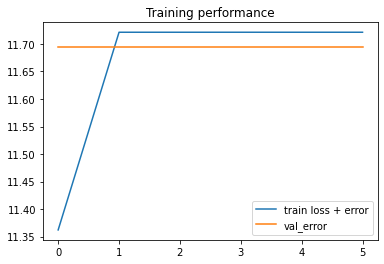

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

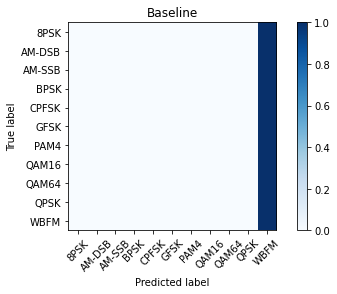

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08766716196136701


Overall Accuracy:  0.09537892791127542


Overall Accuracy:  0.088016967126193


Overall Accuracy:  0.09346451159522136


Overall Accuracy:  0.08164739884393063


Overall Accuracy:  0.09559613319011816


Overall Accuracy:  0.09530634181297026


Overall Accuracy:  0.0846656976744186


Overall Accuracy:  0.0837770678026269


Overall Accuracy:  0.0916606757728253


Overall Accuracy:  0.09513435003631082


Overall Accuracy:  0.09087630724846736


Overall Accuracy:  0.0937381404174573


Overall Accuracy:  0.08619402985074627


Overall Accuracy:  0.09005763688760807


Overall Accuracy:  0.0933284724753919


Overall Accuracy:  0.09218807848944835


Overall Accuracy:  0.09364422715306506


Overall Accuracy:  0.09727339719970524


Overall Accuracy:  0.08960573476702509


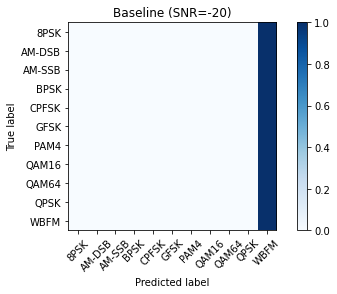

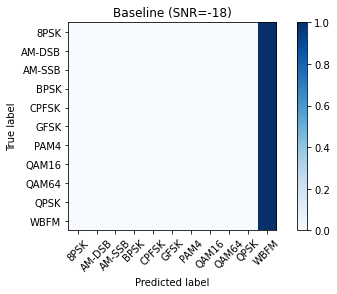

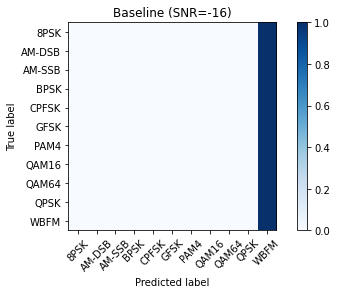

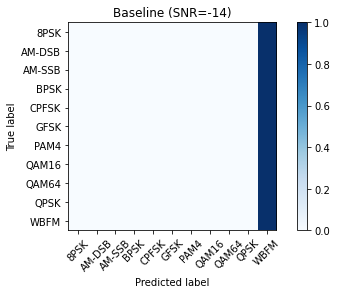

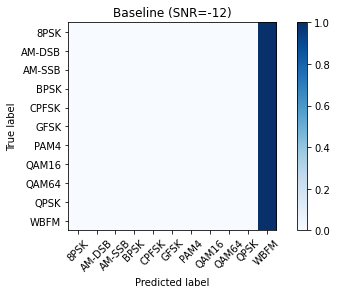

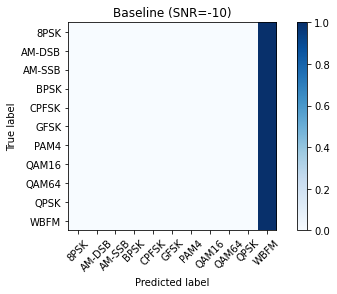

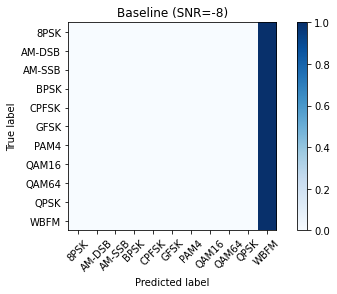

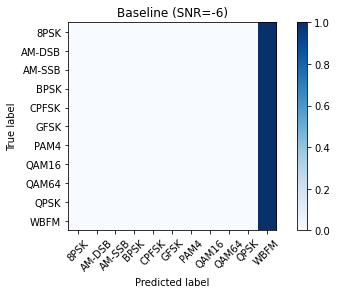

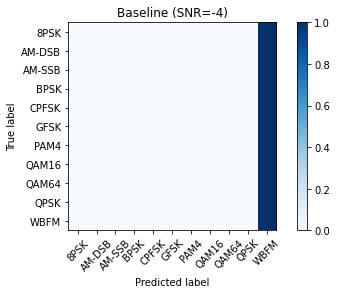

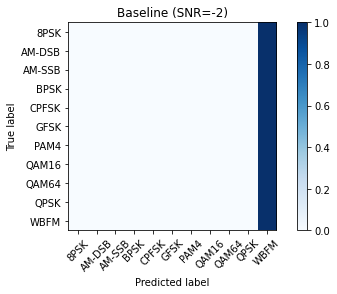

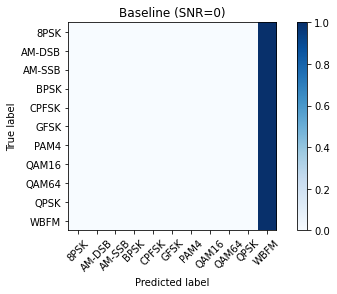

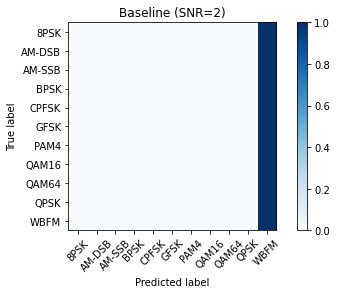

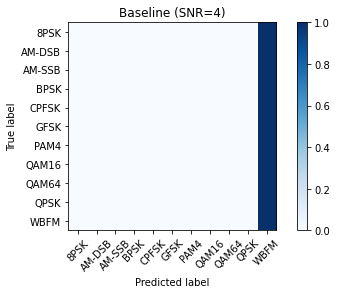

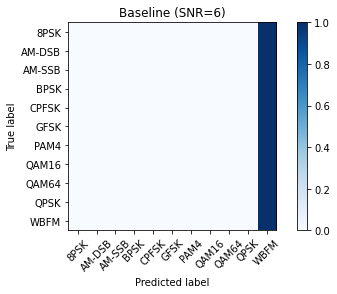

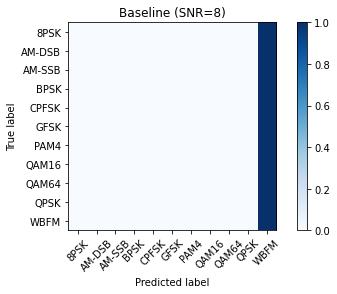

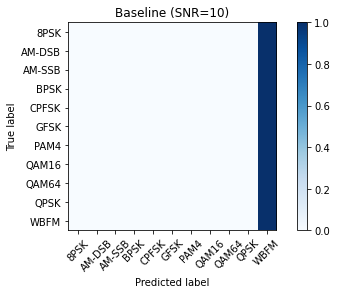

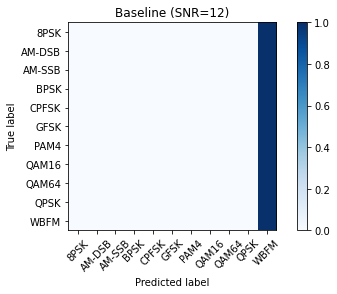

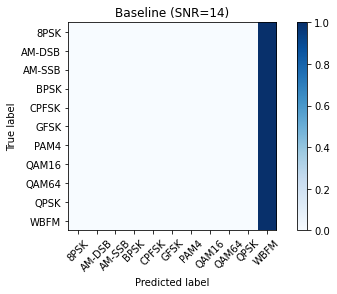

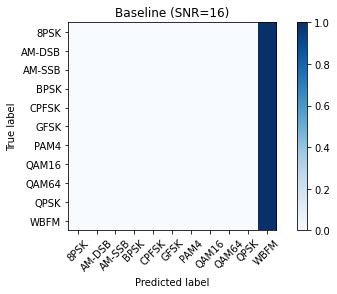

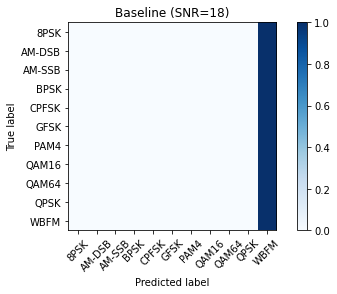

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,8,9,8,9,9,8,8,9,9,9,9,8,9,9,9,9,9,8


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

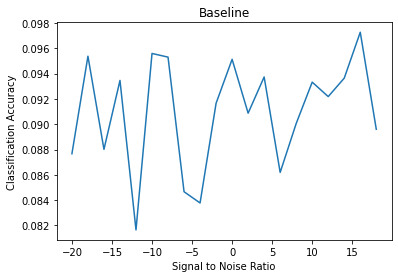

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)